This is the Python implementation of the 3D-RFT Code based on the framework
proposed by Agarwal et al. --> https://doi.org/10.1073/pnas.2214017120

In [2]:
# Main file for executing the analysis of the RFT data
######## IMPORTS ########
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly as py
import scipy as sp
import seaborn as sns
from mpl_toolkits import mplot3d

In [3]:
from src import rft_functions
from src import helper_functions

In [4]:
######## INPUTS ########

## Model selection
MODEL = "CylinderRough"

## Physical properties
BULK_DENSITY = 1310
FRICTION_MATERIAL = 0.21
FRICTION_SURFACE = 0.4
FRICTION_TYPE = "coefficient"
if FRICTION_TYPE == "angle":
    FRICTION_MATERIAL = math.tan(np.deg2rad(FRICTION_MATERIAL))
    FRICTIOON_SURFACE = math.tan(np.deg2rad(FRICTION_SURFACE))
elif FRICTION_TYPE == "coefficient":
    FRICTION_MATERIAL = FRICTION_MATERIAL
    FRICTION_SURFACE = FRICTION_SURFACE
else:
    raise ValueError("FRICTION_UNIT must be either 'angle' or 'coefficient'")
GRAVITY = 9.81
MATERIAL_CONSTANT = (
    GRAVITY
    * BULK_DENSITY
    * (
        894 * FRICTION_MATERIAL**3
        - 386 * FRICTION_MATERIAL**2
        + 89 * FRICTION_MATERIAL
    )
)

## Movement defintions
LINEAR_VELOCITY = 0.1
DIR_ANGLE_XZ_DEG = -90
DIR_ANGLE_Y_DEG = -90

ROTATION = True
ANGULAR_VELOCITY = np.array([0, 0, -2 * sp.pi])

## Depth parameters in mm
DEPTH = 100

## Miscellaneous & Plots
THRESHOLD = 1.0e-12

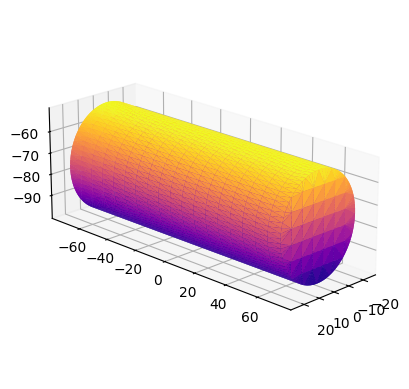

In [6]:
## STL Processing
(
    point_list,
    normal_list,
    area_list,
    depth_list,
    object_width_x,
    object_width_y,
    object_height,
    vertices,
    faces,
    trg,
) = rft_functions.import_mesh(MODEL)
point_list[:, 2] -= DEPTH
vertices[:, 2] -= DEPTH

figure = plt.figure()
axes = figure.add_subplot(111, projection="3d")
axes.plot_trisurf(
    vertices[:, 0],
    vertices[:, 1],
    vertices[:, 2],
    triangles=faces,
    cmap="plasma",
    edgecolor="none",
)
axes.set_box_aspect(
    [np.ptp(vertices[:, 0]), np.ptp(vertices[:, 1]), np.ptp(vertices[:, 2])]
)
axes.view_init(20, 45)

plt.show()

In [ ]:
## Calculate movement
movement = rft_functions.calc_movement(
    point_list,
    DEPTH,
    object_height,
    DIR_ANGLE_XZ_DEG,
    DIR_ANGLE_Y_DEG,
    LINEAR_VELOCITY,
    ROTATION,
    ANGULAR_VELOCITY,
)

In [ ]:
## Check conditions
(
    point_list,
    normal_list,
    area_list,
    depth_list,
    movement,
) = rft_functions.check_conditions(
    point_list, normal_list, area_list, depth_list, movement
)

figure = plt.figure()
axes = figure.add_subplot(111, projection="3d")
axes.quiver(
    point_list[:, 0],
    point_list[:, 1],
    point_list[:, 2],
    movement[:, 0],
    movement[:, 1],
    movement[:, 2],
    length=5,
    normalize=True,
)
axes.set_box_aspect(
    [np.ptp(vertices[:, 0]), np.ptp(vertices[:, 1]), np.ptp(vertices[:, 2])]
)
axes.view_init(45, 45)

plt.show()

In [ ]:
## Find local coordinate frame for each subsurface
z_local, r_local, theta_local = rft_functions.find_local_frame(normal_list, movement)

In [ ]:
## Find the characteristic angles of the RFT method
beta, gamma, psi = rft_functions.find_angles(
    normal_list, movement, z_local, r_local, theta_local
)

In [ ]:
## Find empirical values for the RFT method
f_1, f_2, f_3 = rft_functions.find_fit(beta, gamma, psi)

In [ ]:
## Find dimensionless response vectors alpha
alpha_generic, alpha_generic_n, alpha_generic_t, alpha = rft_functions.find_alpha(
    normal_list,
    movement,
    beta,
    gamma,
    psi,
    z_local,
    r_local,
    theta_local,
    f_1,
    f_2,
    f_3,
    MATERIAL_CONSTANT,
    FRICTION_SURFACE,
)

In [ ]:
forces, pressure, force_x, force_y, force_z, resultant = rft_functions.find_forces(
    alpha, depth_list, area_list
)

In [ ]:
torques, torque_x, torque_y, torque_z, resultant_torque = rft_functions.find_torques(
    point_list, forces
)